## Importing Dependencies

In [93]:
import numpy as np
import pandas as pd
import gc
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import random
import warnings
from feature_engineering import exponential_moving_avg, macd_line, macd_signal, convert_numeric, scale_group

In [65]:
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Loading Dataset

In [2]:
scaled_df = pd.read_csv('10_Year_Historical_Scaled.csv').drop('Unnamed: 0', axis=1)

In [7]:
scaled_df

,Ticker,Date,Adj Close,EMA 20,EMA 50,MACD Line,MACD Signal
0,AAL,2014-10-20,0.505697,0.529674,0.544502,0.607034,0.610477
1,AAL,2014-10-21,0.557537,0.535072,0.546847,0.639224,0.617646
2,AAL,2014-10-22,0.541571,0.538294,0.548377,0.654164,0.626708
3,AAL,2014-10-23,0.569956,0.544164,0.551131,0.682956,0.640369
4,AAL,2014-10-24,0.596369,0.552225,0.554972,0.721051,0.659782
...,...,...,...,...,...,...,...
3221755,ZYXI,2024-10-14,0.308423,0.348974,0.407447,0.406825,0.412171
3221756,ZYXI,2024-10-15,0.307252,0.349241,0.407083,0.411746,0.412160
3221757,ZYXI,2024-10-16,0.304910,0.349227,0.406615,0.414378,0.412735
3221758,ZYXI,2024-10-17,0.307252,0.349470,0.406285,0.418152,0.414030


## Dataset Creation and Train-Test Split

In [104]:
def create_dataset(data, lookback, prediction_horizon):
    n_samples = len(data) - lookback - prediction_horizon
    if n_samples <= 0:
        return np.empty((0, lookback, data.shape[1] - 1)), np.empty((0, prediction_horizon))

    X = np.empty((n_samples, lookback, data.shape[1] - 1), dtype=np.float32)
    Y = np.empty((n_samples, prediction_horizon), dtype=np.float32)

    for i in range(n_samples):
        X[i] = data[i:(i + lookback), 1:]
        Y[i] = data[(i + lookback):(i + lookback + prediction_horizon), 0]

    return X, Y

In [9]:
def process_stock_data(df, lookback, prediction_horizon):
    tickers = df['Ticker'].unique()
    train_x_list, train_y_list, test_x_list, test_y_list = [], [], [], []

    total_train_samples, total_test_samples = 0, 0

    for ticker in tickers:
        stock_data = df[df['Ticker'] == ticker].copy()
        stock_data.drop(columns=['Ticker', 'Date'], inplace=True)

        train_split_len = int(len(stock_data) * 0.8)
        train_data = stock_data.values[:train_split_len]
        test_data = stock_data.values[train_split_len:]

        usable_train_samples = len(train_data) - lookback - prediction_horizon
        usable_test_samples = len(test_data) - lookback - prediction_horizon

        print(f"Ticker: {ticker}, Train rows: {len(train_data)}, Test rows: {len(test_data)}")
        print(f"Ticker: {ticker}, Usable train samples: {usable_train_samples}, Usable test samples: {usable_test_samples}")

        train_x, train_y = create_dataset(train_data, lookback, prediction_horizon)
        test_x, test_y = create_dataset(test_data, lookback, prediction_horizon)

        total_train_samples += train_x.shape[0]
        total_test_samples += test_x.shape[0]

        train_x_list.append(train_x)
        train_y_list.append(train_y)
        test_x_list.append(test_x)
        test_y_list.append(test_y)

        del train_data, test_data
        gc.collect()

    train_x = np.concatenate(train_x_list, axis=0)
    train_y = np.concatenate(train_y_list, axis=0)
    test_x = np.concatenate(test_x_list, axis=0)
    test_y = np.concatenate(test_y_list, axis=0)

    clear_output(wait=True)
    print(f"Total train samples: {total_train_samples}, Total test samples: {total_test_samples}")

    return train_x, train_y, test_x, test_y

In [10]:
lookback = 60
prediction_horizon = 7

train_x, train_y, test_x, test_y = process_stock_data(scaled_df, lookback, prediction_horizon)

gc.collect()

print(f"Training data shape: X={train_x.shape}, Y={train_y.shape}")
print(f"Testing data shape: X={test_x.shape}, Y={test_y.shape}")

Total train samples: 2490880, Total test samples: 559360
Training data shape: X=(2490880, 60, 4), Y=(2490880, 7)
Testing data shape: X=(559360, 60, 4), Y=(559360, 7)


## Model Building and Training

In [119]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [120]:
print(f"Device being used: {device}")

Device being used: cpu


In [127]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=32):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, prediction_horizon)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
train_x_tensor = torch.FloatTensor(train_x).to(device)
train_y_tensor = torch.FloatTensor(train_y).to(device)
test_x_tensor = torch.FloatTensor(test_x).to(device)
test_y_tensor = torch.FloatTensor(test_y).to(device)

In [15]:
input_size = train_x.shape[2]
model = LSTMModel(input_size=input_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [126]:
num_epochs = 5
batch_size = 32

In [13]:
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    num_batches = len(train_x_tensor) // batch_size

    with tqdm(total=num_batches, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
        for i in range(0, len(train_x_tensor), batch_size):
            optimizer.zero_grad()
            x_batch = train_x_tensor[i:i + batch_size]
            y_batch = train_y_tensor[i:i + batch_size]

            y_pred = model(x_batch)

            loss = criterion(y_pred, y_batch)
            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()

            pbar.update(1)
            pbar.set_postfix(loss=loss.item())

    avg_epoch_loss = epoch_loss / num_batches
    elapsed_time = time.time() - start_time
    time_left = (elapsed_time / (epoch + 1)) * (num_epochs - (epoch + 1))

    print(f'Epoch [{epoch + 1}/{num_epochs}], Avg Loss: {avg_epoch_loss:.4f}, Time Elapsed: {elapsed_time:.2f}s, Estimated Time Left: {time_left:.2f}s')

Epoch 1/5: 100%|██████████| 77840/77840 [04:34<00:00, 283.68batch/s, loss=0.000394]


Epoch [1/5], Avg Loss: 0.0023, Time Elapsed: 274.39s, Estimated Time Left: 1097.57s


Epoch 2/5: 100%|██████████| 77840/77840 [04:34<00:00, 283.95batch/s, loss=0.000418]


Epoch [2/5], Avg Loss: 0.0018, Time Elapsed: 548.53s, Estimated Time Left: 822.79s


Epoch 3/5: 100%|██████████| 77840/77840 [04:35<00:00, 282.79batch/s, loss=0.000423]


Epoch [3/5], Avg Loss: 0.0017, Time Elapsed: 823.79s, Estimated Time Left: 549.19s


Epoch 4/5: 100%|██████████| 77840/77840 [04:35<00:00, 282.73batch/s, loss=0.000417]


Epoch [4/5], Avg Loss: 0.0016, Time Elapsed: 1099.11s, Estimated Time Left: 274.78s


Epoch 5/5: 100%|██████████| 77840/77840 [04:34<00:00, 283.56batch/s, loss=0.000422]

Epoch [5/5], Avg Loss: 0.0016, Time Elapsed: 1373.62s, Estimated Time Left: 0.00s


## Saving the model

In [17]:
torch.save(model.state_dict(), 'LSTM.pth')

## Loading the model

In [130]:
model.load_state_dict(torch.load('LSTM.pth', map_location=device))

/tmp/ipykernel_17357/4194769303.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('LSTM.pth', map_location=device))


<All keys matched successfully>

## Testing

In [132]:
def get_batched_predictions(model, test_x_tensor, batch_size):
    predictions = []
    model.eval()
    with torch.no_grad():
        for i in range(0, len(test_x_tensor), batch_size):
            x_batch = test_x_tensor[i:i + batch_size]
            batch_predictions = model(x_batch)
            predictions.append(batch_predictions.cpu().numpy())
            torch.cuda.empty_cache()
    return np.concatenate(predictions, axis=0)

In [19]:
test_predictions = get_batched_predictions(model, test_x_tensor, batch_size)

test_y_true = test_y_tensor.cpu().numpy()

if len(test_predictions.shape) > 1 and test_predictions.shape[1] > 1:
    test_predictions = test_predictions[:, 0]
    test_y_true = test_y_true[:, 0]

In [20]:
mse = mean_squared_error(test_y_true, test_predictions)
mae = mean_absolute_error(test_y_true, test_predictions)
rmse = root_mean_squared_error(test_y_true, test_predictions)

In [21]:
print("Evaluation Metrics")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean-Squared Error (RMSE): {rmse:.2f}")

Evaluation Metrics
Mean Squared Error (MSE): 0.0013
Mean Absolute Error (MAE): 0.0263
Root Mean-Squared Error (RMSE): 0.04


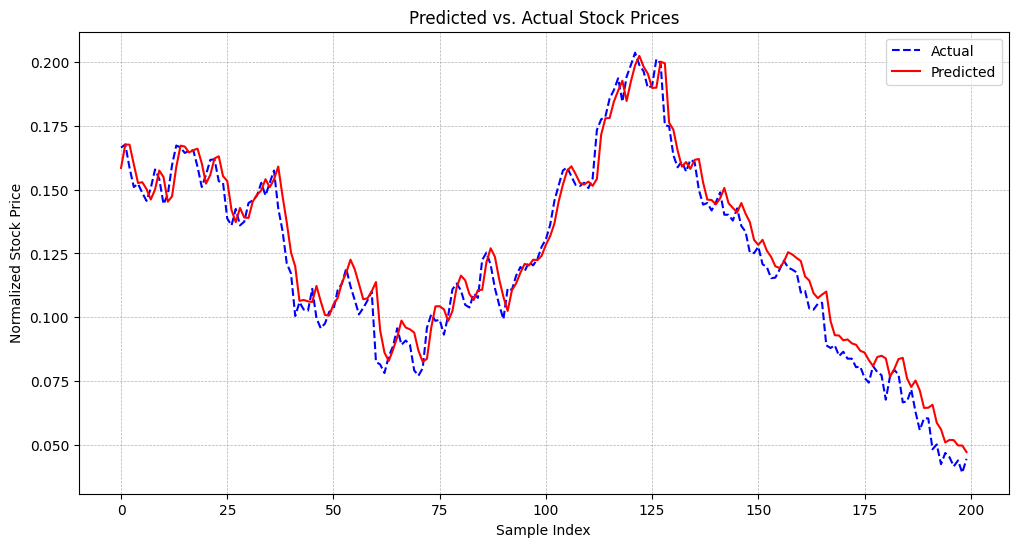

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(test_y_true[:200], label='Actual', color='blue', linestyle='dashed')
plt.plot(test_predictions[:200], label='Predicted', color='red')
plt.title('Predicted vs. Actual Stock Prices')
plt.xlabel('Sample Index')
plt.ylabel('Normalized Stock Price')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

## Generalization Testing

In [12]:
def random_tickers(scaled_df, num_tickers=1000):
    unique_tickers = scaled_df['Ticker'].unique()
    return random.sample(list(unique_tickers), min(num_tickers, len(unique_tickers)))

selected_tickers = random_tickers(scaled_df)

In [13]:
end_date = pd.Timestamp.today()
start_date = end_date - pd.DateOffset(months=10)

In [16]:
df = pd.DataFrame()

with tqdm(total=len(selected_tickers), desc='Fetching Stock Data', unit=' Ticker') as pbar:
    for ticker in selected_tickers:
        stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
        stock_data['Ticker'] = ticker
        stock_data = stock_data[['Ticker', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
        df = pd.concat([df, stock_data])
        pbar.update(1)

Fetching Stock Data: 100%|██████████| 1000/1000 [13:48<00:00,  1.21 Ticker/s]


In [45]:
print(df.shape[0])
211 * 1000

210933


211000

In [30]:
missing_tickers = []
for ticker in df['Ticker'].unique():
    if df[df['Ticker'] == ticker].shape[0] != 211:
        missing_tickers.append(ticker)

In [31]:
missing_tickers

['LUMO', 'ITI', 'SRCL']

In [46]:
df = df[~df['Ticker'].isin(missing_tickers)]

In [49]:
print(df.shape)
df.head(10)

(210367, 7)


,Ticker,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2024-02-20,GLBZ,6.18,6.23,6.18,6.23,5.975924,1700
2024-02-21,GLBZ,6.31,6.31,6.25,6.28,6.023885,2500
2024-02-22,GLBZ,6.58,6.58,6.40,6.45,6.186952,1400
2024-02-23,GLBZ,6.45,6.45,6.45,6.45,6.186952,100
2024-02-26,GLBZ,6.58,6.75,6.58,6.60,6.330835,1100
2024-02-27,GLBZ,6.29,6.60,6.22,6.60,6.330835,2300
2024-02-28,GLBZ,6.26,6.26,6.26,6.26,6.004701,200
2024-02-29,GLBZ,6.29,6.34,6.20,6.20,5.947148,5000
2024-03-01,GLBZ,6.60,6.60,6.22,6.59,6.321243,2100


In [55]:
def rearrange_df(df):
    df = df.reset_index()
    df = df[['Date', 'Ticker', 'Adj Close']]
    df['Date'] = pd.to_datetime(df['Date'])
    return df

df = rearrange_df(df.copy())

In [61]:
df = df.sort_values(by=['Date', 'Ticker']).reset_index(drop=True)

In [66]:
df['EMA 20'] = df.groupby('Ticker').apply(lambda x: exponential_moving_avg(x, price_col='Adj Close', window_size=20)).reset_index(level=0, drop=True)
df['EMA 50'] = df.groupby('Ticker').apply(lambda x: exponential_moving_avg(x, price_col='Adj Close', window_size=50)).reset_index(level=0, drop=True)
df['MACD Line'] = df.groupby('Ticker').apply(lambda x: macd_line(x, price_col='Adj Close')).reset_index(level=0, drop=True)
df['MACD Signal'] = df.groupby('Ticker').apply(lambda x: macd_signal(x, price_col='Adj Close')).reset_index(level=0, drop=True)

In [67]:
df

,Date,Ticker,Adj Close,EMA 20,EMA 50,MACD Line,MACD Signal
0,2024-02-20,AAME,2.487982,2.487982,2.487982,0.000000,0.000000
1,2024-02-20,AAON,81.456718,81.456718,81.456718,0.000000,0.000000
2,2024-02-20,AAPL,180.905411,180.905411,180.905411,0.000000,0.000000
3,2024-02-20,ACAD,24.850000,24.850000,24.850000,0.000000,0.000000
4,2024-02-20,ACHV,4.010000,4.010000,4.010000,0.000000,0.000000
...,...,...,...,...,...,...,...
210362,2024-12-18,ZBRA,383.470001,399.707459,389.058079,2.281997,5.208825
210363,2024-12-18,ZD,55.570000,57.315090,54.416341,1.108484,1.718508
210364,2024-12-18,ZG,72.410004,76.554072,71.164145,1.707850,2.960973
210365,2024-12-18,ZION,53.119999,57.740793,55.834897,-0.125226,0.725610


In [97]:
df = convert_numeric(df)
df = df.groupby('Ticker').apply(scale_group)
df = df.drop('Ticker', axis=1).reset_index().drop('level_1', axis=1)

In [98]:
df

,Ticker,Date,Adj Close,EMA 20,EMA 50,MACD Line,MACD Signal
0,AAME,2024-02-20,0.769344,0.796593,0.846007,0.736258,0.742801
1,AAME,2024-02-21,0.819800,0.802128,0.848551,0.758749,0.747720
2,AAME,2024-02-22,0.906296,0.816626,0.855358,0.814670,0.763885
3,AAME,2024-02-23,0.906296,0.829743,0.861898,0.857588,0.786203
4,AAME,2024-02-26,0.920712,0.843192,0.868908,0.896258,0.812515
...,...,...,...,...,...,...,...
210362,ZYXI,2024-12-12,0.148092,0.066828,0.033293,0.636277,0.627782
210363,ZYXI,2024-12-13,0.145038,0.065429,0.032253,0.635445,0.629658
210364,ZYXI,2024-12-16,0.192366,0.070029,0.033881,0.665797,0.638582
210365,ZYXI,2024-12-17,0.184733,0.073245,0.035022,0.684919,0.650397


In [113]:
def prepare_dataset(df, lookback, prediction_horizon):
    tickers = df['Ticker'].unique()
    X_list, y_list = [], []

    with tqdm(total=len(tickers), desc="Preparing dataset", unit="ticker") as pbar:
        for ticker in tickers:
            stock_data = df[df['Ticker'] == ticker].copy()
            stock_data.drop(columns=['Ticker', 'Date'], inplace=True)

            stock_data_values = stock_data.values
            x, y = create_dataset(stock_data_values, lookback, prediction_horizon)

            X_list.append(x)
            y_list.append(y)

            del stock_data
            gc.collect()

            pbar.update(1)

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)

    print(f"Total samples: {X.shape[0]}")

    return X, y

In [114]:
lookback = 60
prediction_horizon = 7

In [115]:
X, y = prepare_dataset(df, lookback, prediction_horizon)

Preparing dataset: 100%|██████████| 997/997 [08:03<00:00,  2.06ticker/s]


Total samples: 143568


In [117]:
X.shape

(143568, 60, 4)

In [118]:
y.shape

(143568, 7)

In [128]:
input_size = X.shape[2]

In [125]:
X_tensor = torch.FloatTensor(X).to(device)
y_tensor = torch.FloatTensor(y).to(device)

In [129]:
model = LSTMModel(input_size=input_size).to(device)

In [ ]:
def get_batched_predictions(model, test_x_tensor, batch_size):
    predictions = []
    model.eval()
    with torch.no_grad():
        for i in range(0, len(test_x_tensor), batch_size):
            x_batch = test_x_tensor[i:i + batch_size]
            batch_predictions = model(x_batch)
            predictions.append(batch_predictions.cpu().numpy())
            torch.cuda.empty_cache()
    return np.concatenate(predictions, axis=0)

In [134]:
predictions = get_batched_predictions(model, X_tensor, batch_size)

y_true = y_tensor.cpu().numpy()

if len(predictions.shape) > 1 and predictions.shape[1] > 1:
    predictions = predictions[:, 0]
    y_true = y_true[:, 0]

In [135]:
mse = mean_squared_error(y_true, predictions)
mae = mean_absolute_error(y_true, predictions)
rmse = root_mean_squared_error(y_true, predictions)

In [139]:
print("Evaluation Metrics")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean-Squared Error (RMSE): {rmse:.2f}")

Evaluation Metrics
Mean Squared Error (MSE): 0.0080
Mean Absolute Error (MAE): 0.0658
Root Mean-Squared Error (RMSE): 0.09


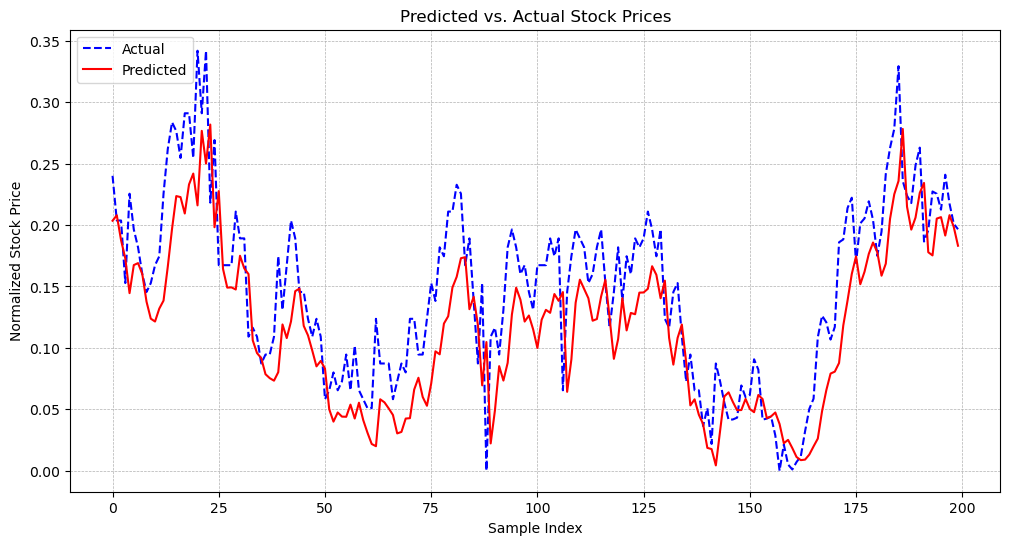

In [141]:
plt.figure(figsize=(12, 6))
plt.plot(y_true[:200], label='Actual', color='blue', linestyle='dashed')
plt.plot(predictions[:200], label='Predicted', color='red')
plt.title('Predicted vs. Actual Stock Prices')
plt.xlabel('Sample Index')
plt.ylabel('Normalized Stock Price')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()